/Users/bellamarco01/uni/2_computational/computational_physics/homework 4/kinetic_energy.py:509: SyntaxWarning: invalid escape sequence '\s'
  - laplacian : float, estimate of \sum_i \nabla^2_i Psi(R)


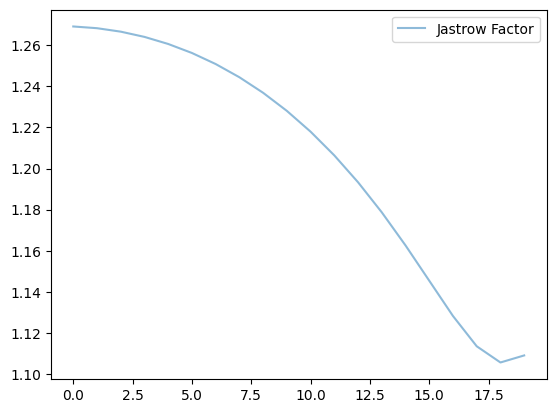

In [2]:
# idea: check numerical vs analytic calculations piece by piece

import numpy as np
import kinetic_energy as kin
import libraryMetropolis as kin2
import importlib
import matplotlib.pyplot as plt

importlib.reload(kin)

def jastrow(N,R,N_up,b_par,b_orth):
    jastrow_log = 0.
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(R[i] - R[j])
    #         print("mb rij",r_ij)
            spin_alignment = 1 if (i < N_up and j < N_up) or (i >= N_up and j >= N_up) else 0
    #         print("spin alignment mb",spin_alignment)
            bij = kin.b_ij(spin_alignment, b_par, b_orth)
            aij = kin.a_ij(spin_alignment)
            jastrow_log += aij * r_ij / (1 + bij * r_ij)
    jastrow_factor = np.exp(jastrow_log)
    return jastrow_factor

box_size = 2 
N = 2
sigma = 1
jastrow_J = lambda X: jastrow(N, X, kin.N_up_choice(N), b_par = 1.0, b_orth = 1.0)
R_test = np.random.uniform(0, box_size, size=(N,2))

length = 20
jastrow_array = np.zeros(length)
jastrow_array_f = np.zeros(length)
for i in range(length):
    R_test[N-1][1]= R_test[N-1][1] + i/200  # Example positions for testing  
    jastrow_array[i] = jastrow(N, R_test, kin.N_up_choice(N), b_par = 1.0, b_orth = 1.0)
plt.plot(np.arange(length), jastrow_array, label='Jastrow Factor',alpha=0.5)
plt.legend()



In [3]:
importlib.reload(kin)
importlib.reload(kin2)
N = 6
R_test = np.random.uniform(0, box_size, size=(N,2))
jastrow_laplacian_mb = kin.jastrow_laplacian(N, kin.N_up_choice(N),R_test, b_par = 1.0, b_orth =1.0)
jastrow_laplacian_mb_old = kin2.jastrow_laplacian(N, kin.N_up_choice(N),R_test, b_par = 1.0, b_orth =1.0)
jastrow_laplacian_comp = kin.numerical_integrand(jastrow_J, N, R_test, return_laplacian = True)

print("Jastrow Laplacian (MB):", jastrow_laplacian_mb)
print("Jastrow Laplacian (Comp):", jastrow_laplacian_comp)

Jastrow Laplacian (MB): 443.85942594869374
Jastrow Laplacian (Comp): 443.8586415744794


is the numerical laplacian ill?

In [4]:
def test_wavefunction(R, alpha=1.0):
    r = R[0]
    v = R[1]
    x, y = r
    z, w = v
    return np.exp(-alpha * (x**2 + y**2)) * np.exp(-alpha * (z**2 + w**2))

def analytical_laplacian(R, alpha=1.0):
    r = R[0]
    v = R[1]
    x, y = r
    z, w = v
    psi = test_wavefunction(R, alpha)
    return (4 * alpha**2 * (x**2 + y**2 + z**2 + w**2) - 8 * alpha) * psi

R_test2 = np.random.uniform(0, box_size, size=(2, 2))  # Two particles in 2D
numerical = kin.numerical_integrand(test_wavefunction, 2, R_test2, return_laplacian=True, h=1e-4)
analytic = analytical_laplacian(R_test2, alpha=1.0)
print("Numerical Laplacian:", numerical)
print("Analytical Laplacian:", analytic)

Numerical Laplacian: 0.05297437041980324
Analytical Laplacian: 0.05297436987262432


Second bit- gradient gradient term, check with numerics

In [64]:
import numpy as np

def numerical_gradient_i(f, R, i, h=1e-5):
    """
    Compute gradient ∇_i f(R) w.r.t. particle i's coordinates in R (shape 2xN).

    Parameters:
    - f : callable, scalar function of R (shape (2,N))
    - R : np.ndarray, shape (N,2), positions of particles
    - i : int, index of the particle to differentiate with respect to
    - h : float, finite difference step

    Returns:
    - grad_i : np.ndarray of shape (2,), [∂f/∂x_i, ∂f/∂y_i]
    """
    grad_i = np.zeros(2)
    
    for dim in range(2):  # 0 for x, 1 for y
        R_forward = R.copy()
        R_backward = R.copy()
        
        R_forward[i,dim] += h
        R_backward[i,dim] -= h

        grad_i[dim] = (f(R_forward) - f(R_backward)) / (2 * h)

    return grad_i

sigma = 1.
def grad_prod(R):
    return kin2.total_wf(N,kin.N_up_choice(N),R,sigma,b_par=1,b_orth=1,return_A=False,jj=False)[0]



grad_J = lambda R,i: numerical_gradient_i(jastrow_J,R,i)
grad_det = lambda R,i: numerical_gradient_i(grad_prod,R,i)
N=5
R_test = np.random.uniform(0, box_size, size=(N,2))

grad_grad_term = 0

psi, det_up, det_down, A_up, A_down = kin2.total_wf(N,kin.N_up_choice(N),R_test,sigma,b_par=1,b_orth=1,return_A=True,jj=True)
A_up_inv = kin.safe_invert_matrix(A_up)
A_down_inv = kin.safe_invert_matrix(A_down)
for i in range(N):
    grad_J_eval = grad_J(R_test,i)
    grad_det_eval = grad_det(R_test,i)
    grad_grad_term += np.dot(grad_J_eval, grad_det_eval)
grad_grad_term_mb = psi * kin.gradient_gradient_term(N, kin.N_up_choice(N), R_test,A_up_inv,A_down_inv, b_par=1.0, b_orth=1.0,sigma=sigma)

print("Gradient gradient term, numeric:", 2*grad_grad_term)
print("Gradient gradient term, gangsta:", grad_grad_term_mb)




fuck [10.81103506 15.17466452]
fuck [-66.36362129 -23.05805743]
Gradient gradient term, numeric: 4.213184783209608e-05
Gradient gradient term, gangsta: 0.0006828830874064329


In [199]:
# stephy curry step back & see if at least the slater gradients agree :c

det_up_f = lambda R: kin2.total_wf(N,kin.N_up_choice(N),R,sigma,b_par=1,b_orth=1,return_A=True,jj=True)[1]

det_up_g = lambda R,i: numerical_gradient_i(det_up_f, R,i)

N=5
R_test = np.random.uniform(0, box_size, size=(N,2))
N_up = kin.N_up_choice(N)
psi, det_up, det_down, A_up, A_down = kin2.total_wf(N,kin.N_up_choice(N),R_test,sigma,b_par=1,b_orth=1,return_A=True,jj=True)
A_up_inv = kin.safe_invert_matrix(A_up)
A_down_inv = kin.safe_invert_matrix(A_down)
grad_det_up_tot = np.zeros(2)
grad_det_up_tot_mb = np.zeros(2)
for i in range(N_up):
    det_up_value = det_up_g(R_test,i)
    det_up_value_mb = kin.slater_gradient(N_up, R_test[:N_up],A_up_inv, i, sigma)
    grad_det_up_tot += det_up_value
    grad_det_up_tot_mb += det_up_value_mb
grad_det_up_tot_mb *= det_up

print("Slater gradient term, numeric:", grad_det_up_tot)
print("Slater gradient term, gangsta:", grad_det_up_tot_mb)


Slater gradient term, numeric: [-0.0010618  -0.00096985]
Slater gradient term, gangsta: [ 9.95792402e-05 -4.54056865e-04]


In [179]:
# see if it is the goddamn Jastrow fucktor
b_par = 1
b_orth = 1
N=5
R_test = np.random.uniform(0, box_size, size=(N,2))
N_up = kin.N_up_choice(N)
jastrow_factor = lambda R: jastrow(N,R,N_up,b_par,b_orth)


def jastrow_grad_anal(R,i):
    jastrow_grad_piece = np.zeros(2)
    for j in range(N):
        if i == j:
            continue
        else:
            rij = np.linalg.norm(R[i] - R[j])
            spin_alignment = 1 if (i < N_up and j < N_up) or (i >= N_up and j >= N_up) else 0
            aij = kin.a_ij(spin_alignment)
            bij = kin.b_ij(spin_alignment, b_par, b_orth)
            x = 1+bij*rij
            jastrow_prefactor = aij/ x**2 
            jastrow_grad_piece += jastrow_prefactor* (R[i]-R[j])/rij #this guy should be a vector
    return jastrow_grad_piece 

jastrow_grad = np.zeros(2)
jastrow_grad2 = np.zeros(2)
jastrow_grad_mb = np.zeros(2)
for i in range(N):
    num_grad = numerical_gradient_i(jastrow_factor, R_test, i,h=1e-5)
    num_grad2 = numerical_gradient_i(jastrow_factor, R_test, i,h=1e-6)
    anal_grad = jastrow_grad_anal(R_test, i) * jastrow_factor(R_test)
    jastrow_grad[0] += num_grad[0]
    jastrow_grad[1] += num_grad[1]
    jastrow_grad2[0] += num_grad2[0]
    jastrow_grad2[1] += num_grad2[1]
    jastrow_grad_mb[0] += anal_grad[0]
    jastrow_grad_mb[1] += anal_grad[1]
    print(f"Particle {i}: Numerical grad = {num_grad}, Analytical grad = {anal_grad}")

print("jastrow_grad",jastrow_grad)
print("jastrow_grad",jastrow_grad2)
print("jastrow_grad_mb", jastrow_grad_mb)

Particle 0: Numerical grad = [-1.91430092  1.47364252], Analytical grad = [-1.91430092  1.47364252]
Particle 1: Numerical grad = [1.73026446 2.64442523], Analytical grad = [1.73026446 2.64442523]
Particle 2: Numerical grad = [1.48748634 0.86210846], Analytical grad = [1.48748634 0.86210846]
Particle 3: Numerical grad = [-0.5968829  -2.99632259], Analytical grad = [-0.5968829  -2.99632259]
Particle 4: Numerical grad = [-0.70656698 -1.98385361], Analytical grad = [-0.70656698 -1.98385361]
jastrow_grad [ 4.88498020e-10 -8.88171758e-11]
jastrow_grad [1.77635684e-09 2.22044605e-09]
jastrow_grad_mb [1.11022302e-16 0.00000000e+00]
